In [1]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
from cmath import nan
import time
import timeit


In [2]:
def getAcc( pos, mass, G, softening ):
	"""
    Calculate the acceleration on each particle due to Newton's Law 
	pos  is an N x 3 matrix of positions
	mass is an N x 1 vector of masses
	G is Newton's Gravitational constant
	softening is the softening length
	a is N x 3 matrix of accelerations
	"""
	# positions r = [x,y,z] for all particles
	x = pos[:,0:1]
	y = pos[:,1:2]
	z = pos[:,2:3]

	# matrix that stores all pairwise particle separations: r_j - r_i
	dx = x.T - x
	dy = y.T - y
	dz = z.T - z

	# matrix that stores 1/r^3 for all particle pairwise particle separations 
	inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)**(-1.5)
	#inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)


	ax = G * (dx * inv_r3) @ mass
	ay = G * (dy * inv_r3) @ mass
	az = G * (dz * inv_r3) @ mass
	
	# pack together the acceleration components
	a = np.hstack((ax,ay,az))

	return a




@njit('(float64[:,:], float64[:,:], float64, float64)', cache=True, fastmath=True, parallel=True)
def compute_acc_fast(pos, mass, G, softening):
    """ Computes the Acceleration of N bodies
	Args:
		pos (type=np.array, size= Nx3): x, y, z positions of the N particles
		mass (type=np.array, size= Nx1): mass of the particles
        G (float): Newton's Gravitational constant
		softening (float): softening parameter

	Returns:
		acc (type=np.array, size= Nx3): ax, ay, az accelerations of the N particles
	"""
    n = pos.shape[0]

    # Copy the array view so for the next loop to be faster
    x = pos[:,0].copy()
    y = pos[:,1].copy()
    z = pos[:,2].copy()

    # Ensure mass is a contiguous 1D array (cheap operation)
    assert mass.shape[1] == 1
    contig_mass = mass[:,0].copy()

    acc = np.empty((n, 3), pos.dtype)

    for i in prange(n):
        ax, ay, az = 0.0, 0.0, 0.0

        for j in range(n):
            dx = x[j] - x[i]
            dy = y[j] - y[i]
            dz = z[j] - z[i]
            tmp = (dx**2 + dy**2 + dz**2 + softening**2)
            factor = contig_mass[j] / (tmp * np.sqrt(tmp))
            ax += dx * factor
            ay += dy * factor
            az += dz * factor

        acc[i, 0] = G * ax
        acc[i, 1] = G * ay
        acc[i, 2] = G * az

    return acc

In [3]:
np.random.seed(123) 
number1=16
N1=np.logspace(1, 6, num=number1, endpoint=True,dtype=int)
t1=np.empty(number1)
G=1.0
softening=0.1
dt=0.01


In [4]:
N1

array([     10,      21,      46,     100,     215,     464,    1000,
          2154,    4641,   10000,   21544,   46415,  100000,  215443,
        464158, 1000000])

In [5]:
for i in range(1):
    pos=np.random.uniform(low=-10, high=10, size=(N1[i],3)) # Random uniform positions
    mass=np.random.uniform(low=1, high=20, size=(N1[i],1)) # Random uniform masses 
    t1[i]= min(timeit.repeat(stmt='compute_acc_fast(pos, mass, G, softening)',\
                      timer=time.perf_counter,repeat=2, number=1,globals=globals()) ) 
    
t1[0]

1.0441988706588745e-05

In [6]:
for i in range(len(N1)):
    pos=np.random.uniform(low=-10, high=10, size=(N1[i],3)) # Random uniform positions
    mass=np.random.uniform(low=1, high=20, size=(N1[i],1)) # Random uniform masses 
    if i==0:
        t1[i]= min(timeit.repeat(stmt='compute_acc_fast(pos, mass, G, softening)',\
                      timer=time.perf_counter,repeat=2, number=1,globals=globals()) )
    else:
        t1[i]= min(timeit.repeat(stmt='compute_acc_fast(pos, mass, G, softening)',\
                      timer=time.perf_counter,repeat=1, number=1,globals=globals()) ) 
    

In [10]:
for i in range(4):
    pos=np.random.uniform(low=-10, high=10, size=(N1[i],3)) # Random uniform positions
    mass=np.random.uniform(low=1, high=20, size=(N1[i],1)) # Random uniform masses 
  
    t1[i]= min(timeit.repeat(stmt='compute_acc_fast(pos, mass, G, softening)',\
                      timer=time.perf_counter,repeat=3, number=1,globals=globals()) ) 

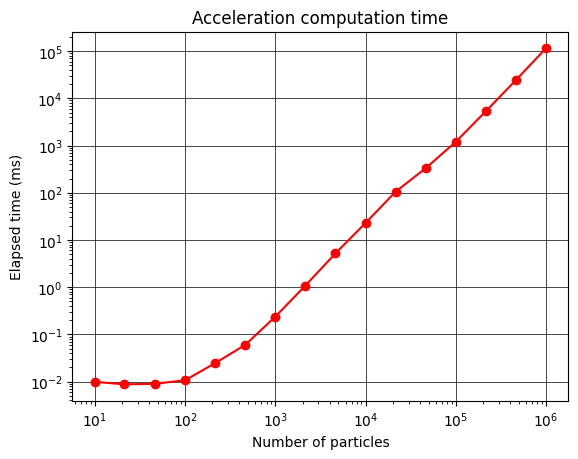

In [11]:
plt.loglog(N1,t1*1e3,"ro-")
plt.xlabel("Number of particles")
plt.ylabel("Elapsed time (ms)")
plt.title("Acceleration computation time")
plt.grid(color='k',linewidth=0.5)

In [20]:
number2=11
t2=np.empty(number2)
N2=N1[0:number2]
for i in range(len(N2)):
    print(i)
    pos=np.random.uniform(low=-10, high=10, size=(N2[i],3)) # Random uniform positions
    mass=np.random.uniform(low=1, high=20, size=(N2[i],1)) # Random uniform masses 
    t2[i]= min(timeit.repeat(stmt='getAcc(pos, mass, G, softening)',\
                      timer=time.perf_counter,repeat=2, number=1,globals=globals()) ) 

0
1
2
3
4
5
6
7
8
9
10


In [21]:
t1

array([9.89809632e-06, 8.76374543e-06, 8.96863639e-06, 1.07251108e-05,
       2.45980918e-05, 6.01634383e-05, 2.37599015e-04, 1.08322874e-03,
       5.20900451e-03, 2.28782315e-02, 1.05241230e-01, 3.30225181e-01,
       1.19714723e+00, 5.30252922e+00, 2.42492480e+01, 1.14457732e+02])

In [22]:
t2

array([1.14757568e-04, 1.29856169e-04, 2.62608752e-04, 2.32040882e-04,
       7.89174810e-04, 3.58397141e-03, 1.81693286e-02, 1.16639752e-01,
       5.09528482e-01, 2.22035041e+00, 1.02312976e+01])

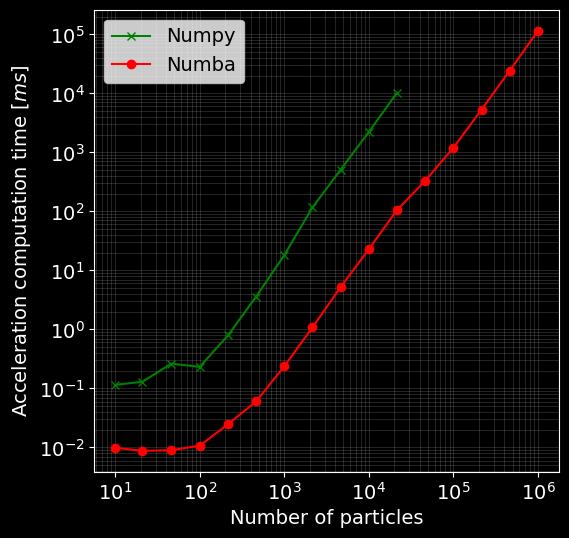

In [23]:
fig = plt.figure(figsize=(6, 6), facecolor='k')
ax = fig.add_subplot(111, facecolor='k')

ax.loglog(N2,t2*1000,"gx-",label="Numpy")
ax.loglog(N1,t1*1000,"ro-",label="Numba")
ax.set_xlabel("Number of particles")
ax.set_ylabel("Elapsed time (ms)")
ax.legend(["Numpy", "Numpy + Numba"])
# ax.set_title("Acceleration computation time", size=14, color='w')
ax.grid(color='k',linewidth=0.5)

ax.set_xlabel('Number of particles', size=14, color='w')
ax.set_ylabel('Acceleration computation time [$ms$]', size=14, color='w')

ax.legend(fontsize=14)
ax.grid(True, which='both', color='w', linestyle='-', linewidth=0.5,alpha=0.2)

# Customizing tick parameters for x and y axes
ax.tick_params(axis='x', colors='w', labelsize=14)
ax.tick_params(axis='y', colors='w', labelsize=14)


# Changing spine colors to white
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['top'].set_color('w')

plt.savefig("numba.png", format='png', bbox_inches='tight')


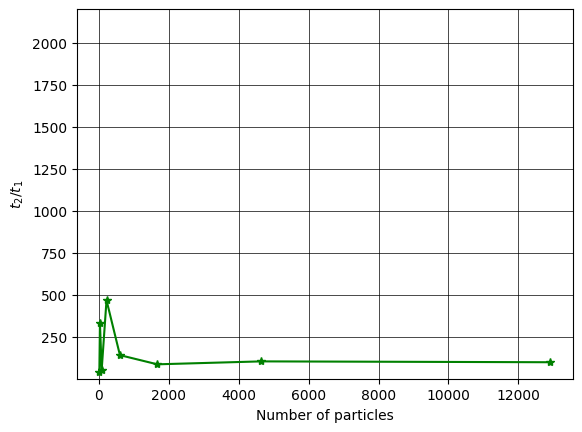

In [10]:
plt.plot(N2,t2/t1[:len(N2)],"g*-")
plt.xlabel("Number of particles")
plt.ylabel("$t_2$/$t_1$")
plt.ylim([1, 2200])
plt.grid(color='k',linewidth=0.5)


In [11]:
C_DF = np.genfromtxt('marshall_DF.csv', delimiter=',')

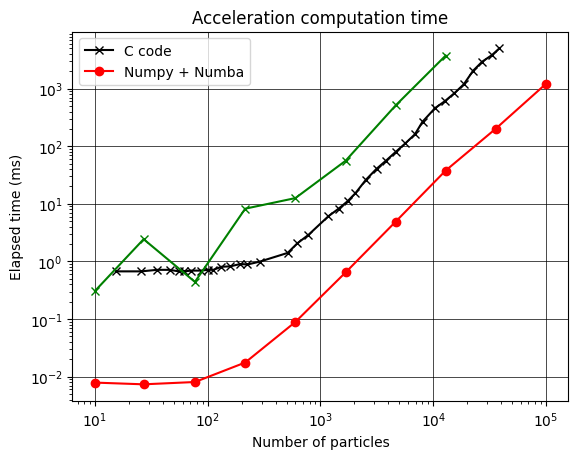

In [13]:
plt.loglog(C_DF[:,0],C_DF[:,1],"kx-")
plt.loglog(N1,t1*1000,"ro-")
plt.loglog(N2,t2*1000,"gx-")
plt.xlabel("Number of particles")
plt.ylabel("Elapsed time (ms)")
plt.legend(["C code", "Numpy + Numba"])
plt.title("Acceleration computation time")
plt.grid(color='k',linewidth=0.5)